Проанализируем отзывы на фильмы с imdb. 25000 записей. У нас есть обучающий набор: 12500 отзывов помечены как хорошие, еще 12500 - как плохие.
Чтобы векторизировать их применим метод bag of words.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
#sharper plots
%config InlineBackend.figure_format = 'retina'
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
PATH_TO_IMDB = "aclimdb"

reviews_train = load_files(
    os.path.join(PATH_TO_IMDB, "train"), categories=["pos", "neg"]
)

text_train, y_train = reviews_train.data, reviews_train.target
reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"), categories=["pos", "neg"])
text_test, y_test = reviews_test.data, reviews_test.target

In [3]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in training data: 25000
[12500 12500]
Number of documents in test data: 25000
[12500 12500]


# Word Count

In [4]:
cv = CountVectorizer()
cv.fit(text_train)
len(cv.vocabulary_)

74849

Рассмотрим получившиеся слова, можем называть их токены. Мы опустили многие важные этапы обработки текста

In [5]:
print(cv.get_feature_names_out()[:50])
print(cv.get_feature_names_out()[50000:50050])

['00' '000' '0000000000001' '00001' '00015' '000s' '001' '003830' '006'
 '007' '0079' '0080' '0083' '0093638' '00am' '00pm' '00s' '01' '01pm' '02'
 '020410' '029' '03' '04' '041' '05' '050' '06' '06th' '07' '08' '087'
 '089' '08th' '09' '0f' '0ne' '0r' '0s' '10' '100' '1000' '1000000'
 '10000000000000' '1000lb' '1000s' '1001' '100b' '100k' '100m']
['pincher' 'pinchers' 'pinches' 'pinching' 'pinchot' 'pinciotti' 'pine'
 'pineal' 'pineapple' 'pineapples' 'pines' 'pinet' 'pinetrees' 'pineyro'
 'pinfall' 'pinfold' 'ping' 'pingo' 'pinhead' 'pinheads' 'pinho' 'pining'
 'pinjar' 'pink' 'pinkerton' 'pinkett' 'pinkie' 'pinkins' 'pinkish'
 'pinko' 'pinks' 'pinku' 'pinkus' 'pinky' 'pinnacle' 'pinnacles' 'pinned'
 'pinning' 'pinnings' 'pinnochio' 'pinnocioesque' 'pino' 'pinocchio'
 'pinochet' 'pinochets' 'pinoy' 'pinpoint' 'pinpoints' 'pins' 'pinsent']


In [6]:

X_train = cv.transform(text_train)
X_test = cv.transform(text_test)
X_train

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3445861 stored elements and shape (25000, 74849)>

Рассмотрим результат

In [7]:
print(text_train[19726])
X_train[19726].nonzero()

b'This movie is terrible but it has some good effects.'


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
        66562], dtype=int32))

**Обучим логистическую регрессию**

In [8]:
%%time
logit = LogisticRegression(solver="lbfgs", n_jobs=-1, random_state=17)
logit.fit(X_train, y_train)

CPU times: user 48.1 ms, sys: 151 ms, total: 199 ms
Wall time: 6.28 s


/Users/sergey/Documents/Computer Science/machine learning/mlcourse_ai/Linear Classification and Regression/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(n_jobs=-1, random_state=17)

In [9]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3),

(0.982, 0.863)

Визулизируем веса можели

In [10]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(1, 1 + 2 * n_top_features),
        feature_names[interesting_coefficients],
        rotation=60,
        ha="right",
    )

def plot_grid_scores(grid, param_name):
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_train_score"],
        color="green",
        label="train",
    )
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_test_score"],
        color="red",
        label="test",
    )
    plt.legend()

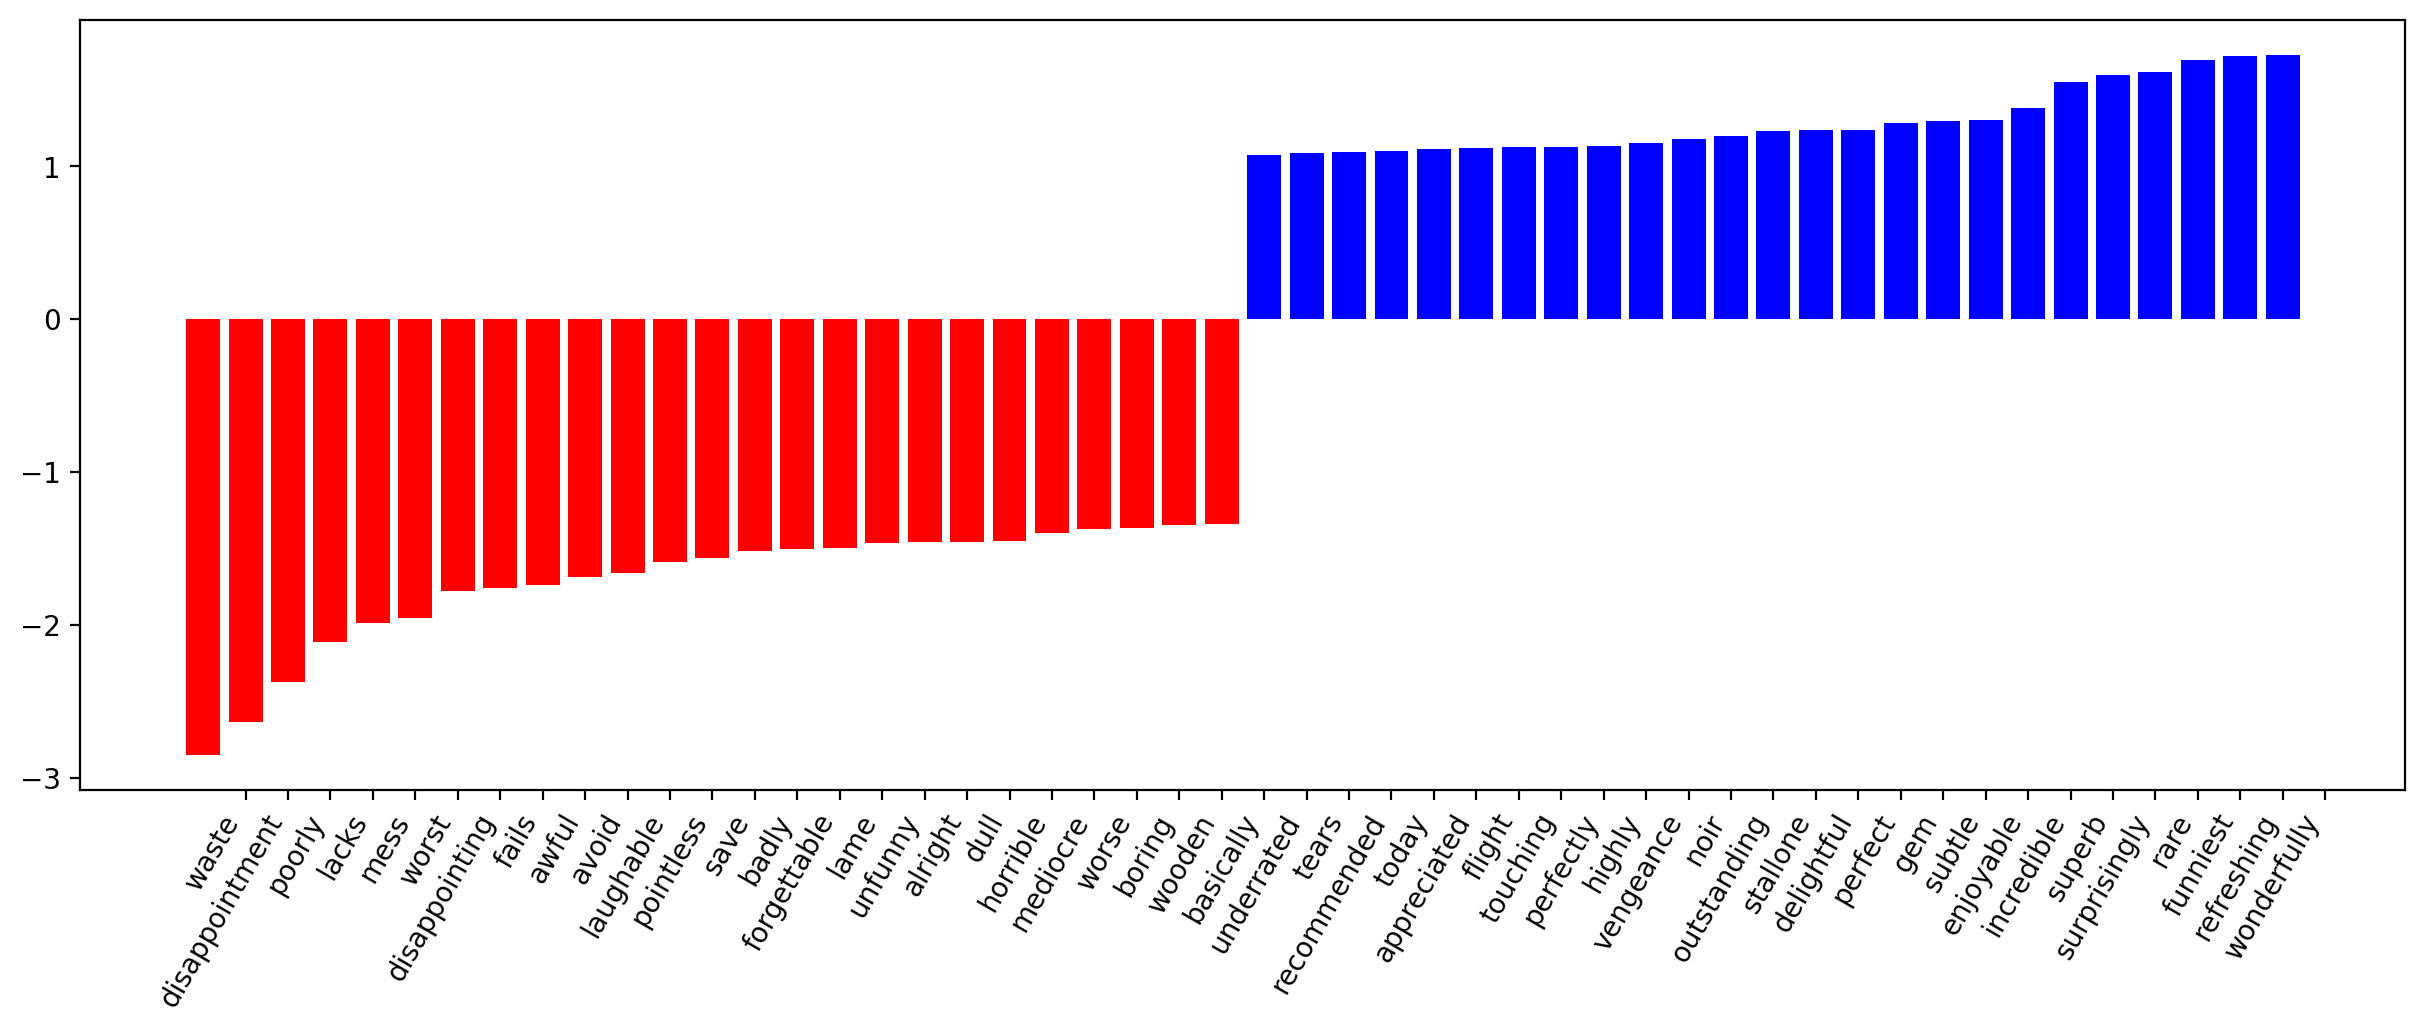

In [11]:
visualize_coefficients(logit, cv.get_feature_names_out())


Чтобы оптимизировать модель, оптимизируем коэфицент регулизации. Построим пайплайн, CountVectorizer будем применять, только на обучающих данных.

In [ ]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(
    CountVectorizer(),
    LogisticRegression(solver="lbfgs", n_jobs=1, random_state=7)
)

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_train, y_test), text_pipe_logit.score(text_test, y_test)) # 0.98128 0.86408

/Users/sergey/Documents/Computer Science/machine learning/mlcourse_ai/Linear Classification and Regression/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.98128 0.86408
CPU times: user 2min 52s, sys: 25.6 s, total: 3min 18s
Wall time: 42.8 s


In [13]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {"logisticregression__C": np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(
    text_pipe_logit, param_grid_logit, return_train_score=True, cv=3, n_jobs=-1
)

grid_logit.fit(text_train, y_train)

/Users/sergey/Documents/Computer Science/machine learning/mlcourse_ai/Linear Classification and Regression/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sergey/Documents/Computer Science/machine learning/mlcourse_ai/Linear Classification and Regression/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

CPU times: user 2min 34s, sys: 30.7 s, total: 3min 5s
Wall time: 1min 17s


/Users/sergey/Documents/Computer Science/machine learning/mlcourse_ai/Linear Classification and Regression/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(n_jobs=1,
                                                           random_state=7))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
             return_train_score=True)

Узнаем лучший коэф регулизации, и результат модели

In [14]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': np.float64(0.1)}, np.float64(0.8854799308363024))

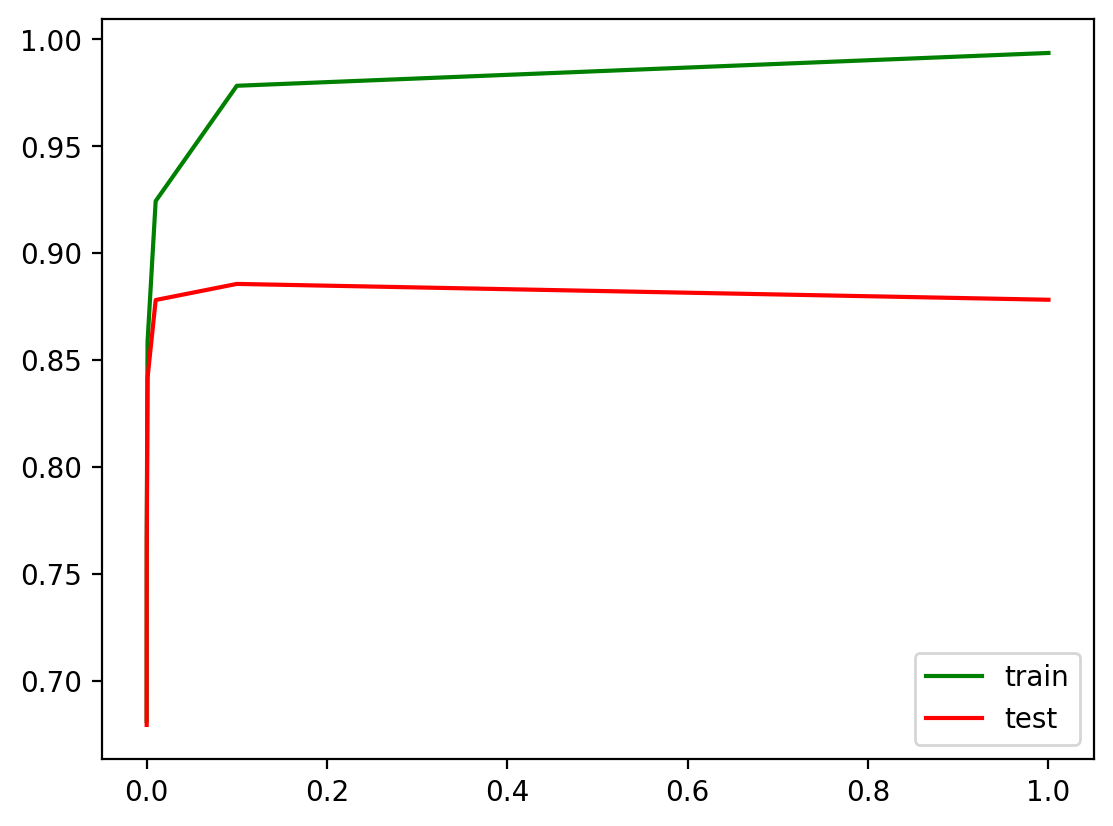

In [ ]:
plot_grid_scores(grid_logit, "logisticregression__C")

In [16]:
grid_logit.score(text_test, y_test)

0.87812

## The XOR Problem
Рассмотрим случай когда линейны модели очень плохи.
Линейные методы классфикации определяют очень простую разделяющую поверхность - гиперплоскость.
Самая популярная задача, которая не может быть раделена гиперплоскостью без ошибок "the xor problem"


In [26]:
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

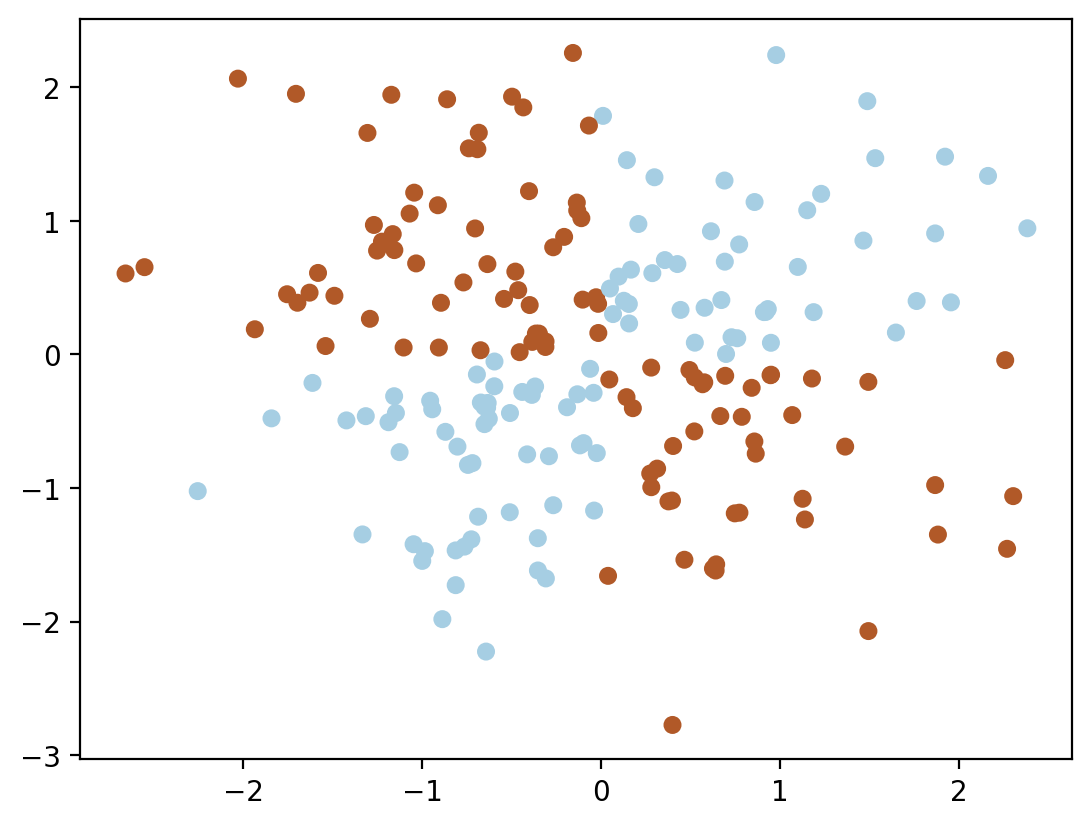

In [32]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)

Очевидно, что невозможно провести ни одной прямой линии, чтобы отделить один класс от другого без ошибок. Поэтому логистическая регрессия плохо справляется с этой задачей.

In [33]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="auto",
        origin="lower",
        cmap=plt.cm.PuOr_r,
    )
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes="--")
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

/var/folders/n_/fptkl59n3m546hy_tw45d7lc0000gn/T/ipykernel_35157/3069517639.py:16: UserWarning: The following kwargs were not used by contour: 'linetypes'
  contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes="--")


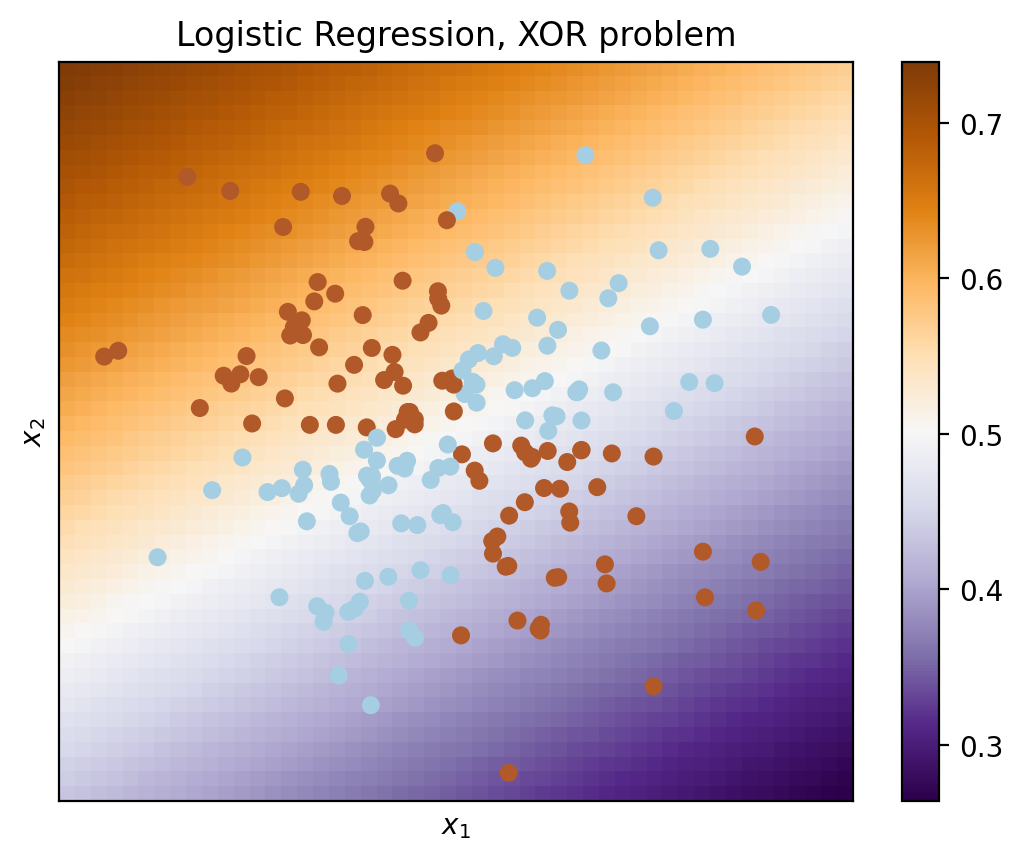

In [34]:
plot_boundary(
    LogisticRegression(solver="lbfgs"), X, y, "Logistic Regression, XOR problem"
)

Но если в качестве входных данных ввести полиномиальные признаки (здесь до 2 степеней), то проблема будет решена.

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [48]:
logit_pipe = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2)),
        ("logit", LogisticRegression(solver="lbfgs")),
    ]
)

/var/folders/n_/fptkl59n3m546hy_tw45d7lc0000gn/T/ipykernel_35157/3069517639.py:16: UserWarning: The following kwargs were not used by contour: 'linetypes'
  contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes="--")


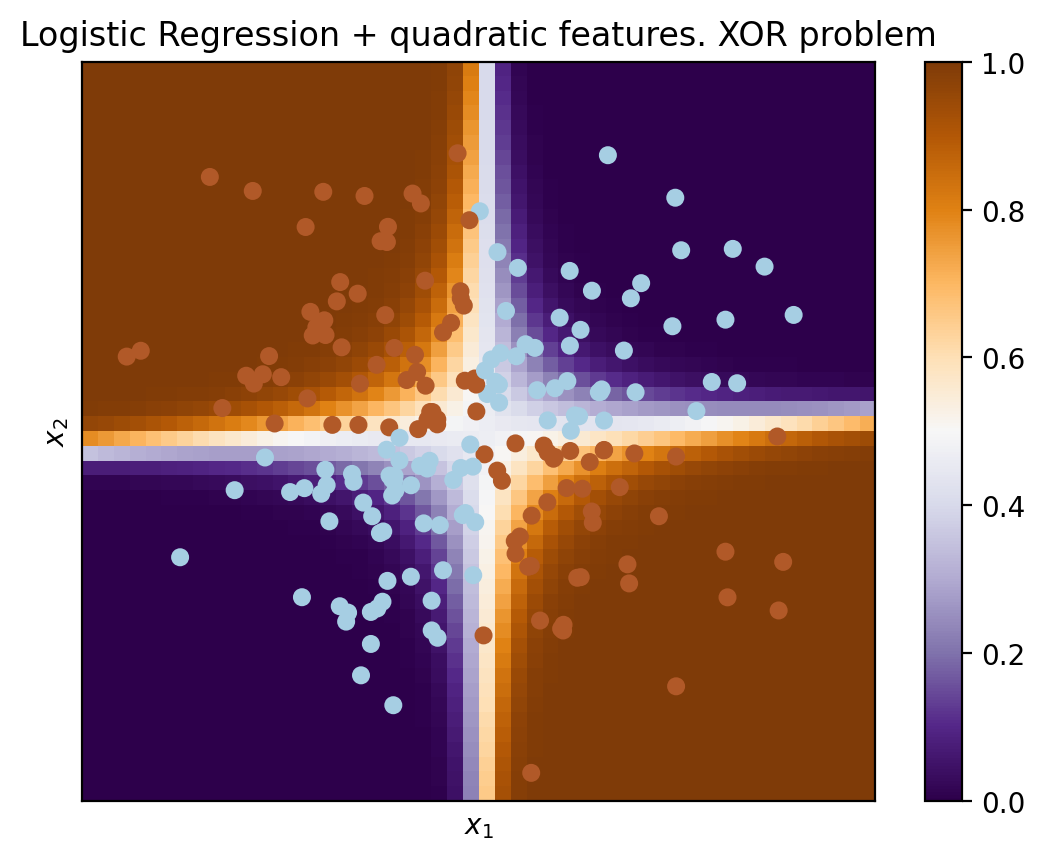

In [49]:
plot_boundary(logit_pipe, X, y, "Logistic Regression + quadratic features. XOR problem")

В данном случае логистическая регрессия все еще создает гиперплоскость, но в 6-мерном пространстве признаков. Когда мы проецируем на исходное, то граница оказывается нелинейной.

На практике полиномиальные объекты действительно помогают, но их явное построение неэффективно с точки зрения вычислений. SVM с помощью трюка с ядром работает намного быстрее. При таком подходе вычисляется только расстояние между объектами (определяемое функцией ядра) в многомерном пространстве, и нет необходимости создавать комбинаторно большое количество объектов.